In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchaudio
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython.display as ipd
from datetime import datetime
import time
from scipy import signal

from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy, MultilabelAccuracy
import audiomentations
from torch.utils.data import default_collate
from torchvision.transforms import v2
import timm

from src.audio_utils import play_audio, plot_specgram, plot_waveform
from src.data import AudioDataset, FrequencyMaskingAug, TimeMaskingAug, CutMix, MixUp
from src.data_utils import get_metadata, get_fold, get_metadata_from_csv
from src.train_utils import FocalLoss, BCEFocal2WayLoss, get_cosine_schedule_with_warmup, wandb_init, train_one_epoch, eval_one_epoch
from src.models import AudioGeMSEDClassifier
from src.utils import score_np, roc_auc

import ast
import wandb
import yaml

/home/cedric/miniconda3/envs/birds/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [2]:
class Config:
    start_idx = 'first'
    use_1_peak = True
    peak_filter = 'savgol'
    use_peaks = False
    duration = 10 # 10

    sample_rate = 32000
    target_length = 500 # 500
    n_mels = 128
    n_fft = 1024
    window = 160 # 800
    audio_len = duration*sample_rate
    #hop_length = audio_len // (target_length-1)
    hop_length = 64
    fmin = 50
    fmax = 16000
    top_db = 80
    
    n_classes = 182
    batch_size = 32
    Model = AudioGeMSEDClassifier
    model_name = 'mn20_as'  # dymn10_as mn20_as tf_efficientnetv2_s
    n_channels = 1
    n_folds = 5
    upsample_thr = 25
    use_class_weights = True   # Test

    standardize = False
    dataset_mean = [-16.8828]
    dataset_std = [12.4019]

    data_aug = True     # Test     
    cutmix_mixup = False     # Test
    loss = 'crossentropy'    # Test ('crossentropy', 'bce')
    secondary_labels_weight = 0.3   # Test (0)
    use_focal = False    # Test (only with bce)
    use_2wayfocal = False
    focal_gamma = 2
    focal_lambda = 1
    label_smoothing = 0.05  # Only with crossentropy

    folds = [2]
    num_epochs = 30
    warmup_epochs = 1
    lr = 1e-3
    start_lr = 0.001 # relative to lr
    final_lr = 0.001
    weight_decay = 0.0001
    max_grad_norm = 10

    wandb = False
    competition   = 'birdclef-2024' 
    _wandb_kernel = 'cvincent13'
    date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    run_name = f"{date}_{n_mels}x{target_length}_{model_name}"
    wandb_group = 'FullCV'

    base_dir = ''
    short_noises = 'data/background/esc50/use_label'
    background_noises = ['data/background/aicrowd2020_noise_30sec/noise_30sec',
                         'data/background/ff1010bird_nocall/nocall',
                         #'data/background/train_soundscapes/nocall'
                        ]

#metadata = get_metadata(Config.n_folds)
metadata = get_metadata_from_csv('metadata.csv', 'data')

### Dataset

In [3]:
# Data transforms and augmentations
waveform_transforms = audiomentations.Compose([
    audiomentations.Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
    audiomentations.SevenBandParametricEQ(min_gain_db=-12., max_gain_db=12., p=0.2),
    audiomentations.AirAbsorption(min_temperature=10, max_temperature=20, min_humidity=30, max_humidity=90,
                                  min_distance=10, max_distance=100, p=0.8), 

    audiomentations.OneOf([
        audiomentations.Gain(min_gain_db=-4., max_gain_db=4., p=1), 
        audiomentations.GainTransition(min_gain_db=-12., max_gain_db=3., p=1)
    ], p=0.5),

    audiomentations.OneOf([
        audiomentations.AddGaussianSNR(min_snr_db=5., max_snr_db=40., p=1.),
        audiomentations.AddColorNoise(min_snr_db=5., max_snr_db=40., min_f_decay=-3.01, max_f_decay=-3.01, p=1.)
    ], p=0.5),

    audiomentations.AddShortNoises(sounds_path=Config.short_noises, min_snr_db=5., max_snr_db=30., 
                               noise_rms='relative_to_whole_input',
                               min_time_between_sounds=2., max_time_between_sounds=8., 
                               noise_transform=audiomentations.PolarityInversion(), p=0.4),
    audiomentations.AddBackgroundNoise(sounds_path=Config.background_noises, min_snr_db=5., max_snr_db=30., 
                                   noise_transform=audiomentations.PolarityInversion(), p=0.4),
                                   
    audiomentations.LowPassFilter(min_cutoff_freq=750., max_cutoff_freq=7500., min_rolloff=12, max_rolloff=24, p=0.5),
    audiomentations.PitchShift(min_semitones=-2.5, max_semitones=2.5, p=0.3)
])

spec_transforms = nn.Sequential(
    FrequencyMaskingAug(0.25, 0.1, Config.n_mels, n_masks=3, mask_mode='mean'),
    TimeMaskingAug(0.25, 0.1, Config.target_length, n_masks=3, mask_mode='mean'),
)

waveform_transforms=None if not Config.data_aug else waveform_transforms
spec_transforms=None if not Config.data_aug else spec_transforms


cutmix_or_mixup = v2.RandomApply([
    v2.RandomChoice([
        CutMix(num_classes=Config.n_classes, alpha=0.5, one_hot_labels=Config.loss=='bce'),
        MixUp(num_classes=Config.n_classes, alpha=0.5, one_hot_labels=Config.loss=='bce')
    ], p=[0.65, 0.35])
], p=0.5)


def mix_collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

collate_fn = mix_collate_fn if Config.cutmix_mixup else None


Num Train: 20162, 182 classes | Num Valid: 4892, 182 classes


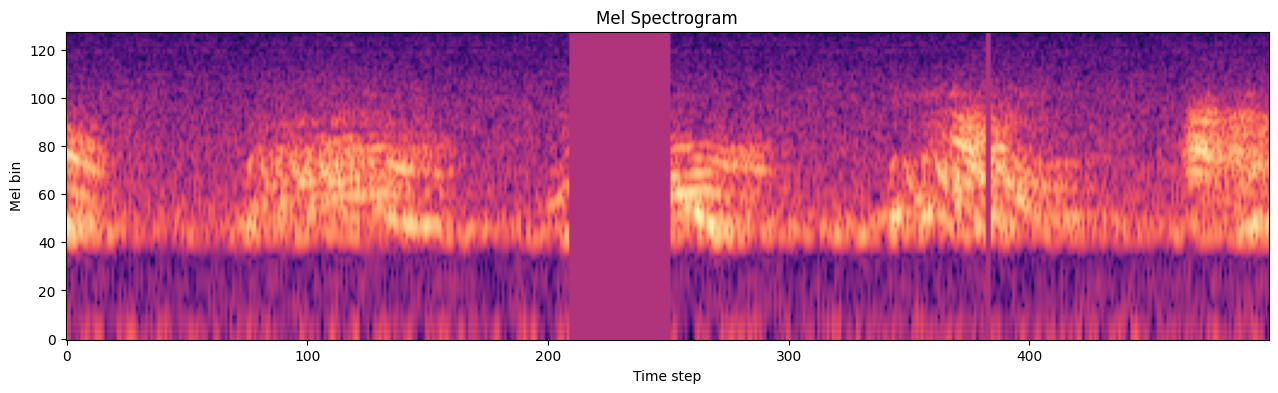

In [4]:
train_df, valid_df, class_weights = get_fold(metadata, 2, up_thr=Config.upsample_thr)

train_dataset = AudioDataset(train_df, Config, waveform_transforms=waveform_transforms, spec_transforms=spec_transforms)
val_dataset = AudioDataset(valid_df, Config, waveform_transforms=None, spec_transforms=None)
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=4)

spec, label = next(iter(train_loader))
plt.figure(figsize=(16,4))
plt.imshow(spec[0,0], origin='lower', cmap='magma')
plt.grid(visible=False)
plt.title('Mel Spectrogram')
plt.xlabel('Time step')
plt.ylabel('Mel bin')
plt.show()

### Training

In [5]:
device = torch.device('cuda')

for fold in Config.folds:
    print(f"Training fold {fold}")
    # Read data
    train_df, valid_df, class_weights = get_fold(metadata, fold, up_thr=Config.upsample_thr)

    # Dataloaders
    train_dataset = AudioDataset(train_df, Config, waveform_transforms=waveform_transforms, spec_transforms=spec_transforms)
    val_dataset = AudioDataset(valid_df, Config, waveform_transforms=None, spec_transforms=None)
    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=4)

    # Model and optim
    model = Config.Model(Config.n_classes, Config.model_name, n_mels=Config.n_mels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=Config.weight_decay, lr=Config.lr)
    spe = len(train_loader)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=spe*Config.warmup_epochs, num_training_steps=spe*Config.num_epochs, 
                                                start_lr=Config.start_lr, final_lr=Config.final_lr)
    
    # Losses and metrics
    pos_weight = torch.tensor(class_weights).to(device) if Config.use_class_weights else None
    if Config.loss == 'crossentropy':
        criterion = nn.CrossEntropyLoss(label_smoothing=Config.label_smoothing, weight=pos_weight)
    elif Config.loss == 'bce':
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight, weight=None)

    focal_criterion = FocalLoss(gamma=Config.focal_gamma, pos_weight=pos_weight)
    focal2way_criterion = BCEFocal2WayLoss(gamma=Config.focal_gamma, pos_weight=pos_weight)

    # Start training
    start_time = time.time()
    if Config.wandb:
        run = wandb_init(fold, Config)

    save_dir = f"{Config.base_dir}checkpoints/{Config.run_name}" + f"_fold-{fold}"
    train_losses = []
    val_losses = []
    train_metrics = {'AUC': [], 'Accuracy': [], 'Score': []}
    val_metrics = {'AUC': [], 'Accuracy': [], 'Score': []}

    for epoch in range(Config.num_epochs):
        train_loss, gt, preds = train_one_epoch(Config, model, train_loader, device, optimizer, scheduler, 
                                                                criterion, focal_criterion, focal2way_criterion)
        train_losses.append(train_loss)
        train_auc = roc_auc(preds, gt)


        val_loss, gt, preds = eval_one_epoch(Config, model, val_loader, device, criterion, focal_criterion, focal2way_criterion)
        val_losses.append(val_loss)
        val_auc = roc_auc(preds, gt)

        save_dict = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "epoch": epoch+1,
            "train_losses": train_losses,
            "train_auc": train_auc,
            "val_losses": val_losses,
            "val_auc": val_auc
        }

        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(save_dict, save_dir + "/checkpoint.pth")
        with open(save_dir + "/config.txt", "a") as f:
            f.write("CONFIG:")
            for k,v in dict(vars(Config)).items():
                if '__' not in k:
                    f.write("\n")
                    f.write(f"{k}: {v}")
        with open(save_dir + "/logs.txt", "a") as f:
            f.write(f"Epoch {epoch+1}: Train Loss = {train_loss:.3f}, Train ROCAUC = {train_auc:.3f}, | Val Loss = {val_loss:.3f}, Val ROCAUC = {val_auc:.3f}")

        if Config.wandb:
            wandb.log({
                "train_loss": train_loss,
                "train_auc": train_auc,
                "val_loss": val_loss,
                "val_auc": val_auc,
                "lr": scheduler.get_last_lr()
            })


        print(f'Epoch {epoch+1}: Train Loss = {train_loss:.3f}, Train ROCAUC = {train_auc:.3f}, | Val Loss = {val_loss:.3f}, Val ROCAUC = {val_auc:.3f}')


    def format_duration(seconds):
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return "{:02}h {:02}min {:02}s".format(int(hours), int(minutes), int(seconds))

    print(f'Done in {format_duration(time.time() - start_time)}')

    if Config.wandb:
        #print('# WandB')
        #log_wandb(valid_df)
        wandb.run.finish()

Training fold 2
Num Train: 20162, 182 classes | Num Valid: 4892, 182 classes


/home/cedric/miniconda3/envs/birds/lib/python3.10/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


Features only is true, Dropping final fully-connected layer and loading weights in non-strict mode


train loss: 5.372:   3%|▎         | 18/631 [00:40<23:12,  2.27s/it] 


KeyboardInterrupt: 

In [3]:
1.75*6

10.5

In [6]:
sum([p.numel() for p in model.parameters()])

16033285

# Optimize for inference

In [17]:
import openvino as ov
import nncf

In [24]:
# Load checkpoint
device = torch.device('cpu')

model = Config.Model(Config.n_classes, pretrained=False, model_name=Config.model_name, n_mels=Config.n_mels).to(device)

#save_dir = f"{Config.base_dir}checkpoints/{Config.run_name}"
save_dir = 'checkpoints/2024-05-31_18-20-02_128x384_mn20_as_fold-2'
checkpoint_name = f'{save_dir}/checkpoint.pth'
checkpoint_ov = f'{save_dir}/checkpoint.xml'
    
checkpoint = torch.load(checkpoint_name, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval()
print('loaded')

loaded


In [25]:
# Convert and save model for openvino
input_data = torch.rand(1, Config.n_channels, Config.n_mels, Config.target_length)
ov_model = ov.convert_model(model, example_input=input_data)
ov.save_model(ov_model, save_dir + '/checkpoint.xml')

In [ ]:
# Read and compile model with openvino
core = ov.Core()
ov_model = core.read_model(save_dir + "/checkpoint.xml")
compiled_model = ov.compile_model(ov_model)

In [ ]:
# Quantize model to 8 bits openvino

val_loader

In [ ]:
target = torch.zeros((8,182))
input = torch.zeros((8,182))